In [1]:
import pandas as pd
import numpy as np 
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error, accuracy_score, log_loss, mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import FeatureAgglomeration
import category_encoders as ce
from numpy.testing import assert_almost_equal
from functools import reduce
import matplotlib.pyplot as plt
import time
from category_encoders.binary import BinaryEncoder
pd.set_option('display.max_columns', None)  # Unlimited columns
import xgboost as xgb
import copy

In [3]:
xgb.__version__

'0.81'

In [4]:
url = "unit-3/train_features.csv"
df = pd.read_csv(url, parse_dates=['date_recorded'],index_col='id' )

In [5]:
df.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [6]:
df.shape

(59400, 39)

In [7]:
df['timestamp'] = df.date_recorded.apply(lambda d: d.timestamp()/ 10 ** 9)
dft = df.drop(['date_recorded', 'region_code', 'district_code', 'region'], inplace = False, axis=1)
dft['region_district'] = df.apply(lambda row: f'{row.region}_{row.district_code}' , axis=1)
train_input_columns = list(dft.columns)
train_numeric_columns = dft.select_dtypes(exclude=['object']).columns
dft.head()

,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,timestamp,region_district
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,1.300061,Iringa_5
8776,0.0,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,1.362528,Mara_2
34310,25.0,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,1.361750,Manyara_4
67743,0.0,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,1.359331,Mtwara_63
19728,0.0,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,1.310515,Kagera_1


In [8]:
dft.shape

(59400, 37)

In [9]:
yurl = 'unit-3/train_labels.csv'
dfy = pd.read_csv(yurl, index_col='id' )
dfy.shape

(59400, 1)

In [10]:
dfum = dft.merge(dfy, left_index=True, right_index=True)

In [11]:
dfum.head()

,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,timestamp,region_district,status_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,1.300061,Iringa_5,functional
8776,0.0,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,1.362528,Mara_2,functional
34310,25.0,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,1.361750,Manyara_4,functional
67743,0.0,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,1.359331,Mtwara_63,non functional
19728,0.0,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,1.310515,Kagera_1,functional


In [12]:
dc = 'status_group'

In [13]:
oc = dfum.select_dtypes(include=['object']).columns
oc = oc.drop(dc)
oc

Index(['funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'lga', 'ward',
       'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name',
       'permit', 'extraction_type', 'extraction_type_group',
       'extraction_type_class', 'management', 'management_group', 'payment',
       'payment_type', 'water_quality', 'quality_group', 'quantity',
       'quantity_group', 'source', 'source_type', 'source_class',
       'waterpoint_type', 'waterpoint_type_group', 'region_district'],
      dtype='object')

In [14]:
hot = []
binary = []
for o in oc:
    if dfum[o].unique().shape[0] > 127:
        print(dfum[o].unique().shape[0], o)
        binary.append(o)
    else:
        hot.append(o)

1898 funder
2146 installer
37400 wpt_name
19288 subvillage
2092 ward
2697 scheme_name
132 region_district


In [15]:
encoders = Pipeline([
                ('binary', BinaryEncoder(cols=binary)),
                ('onehot', ce.OneHotEncoder(use_cat_names=True,cols=hot))
            ])
df_ = encoders.fit_transform(dfum)

In [16]:
de = df_.describe()
ex_oc = df_.columns
drop = []
for o in ex_oc:
    if o in de.columns:
        if de[o]['mean'] == 0:
            drop.append(o)
        # print(de[o].mean)
dfd_ = df_.drop(drop, axis=1)
print(drop)

['basin_-1', 'lga_-1', 'public_meeting_-1', 'recorded_by_-1', 'scheme_management_-1', 'permit_-1', 'extraction_type_-1', 'extraction_type_group_-1', 'extraction_type_class_-1', 'management_-1', 'management_group_-1', 'payment_-1', 'payment_type_-1', 'water_quality_-1', 'quality_group_-1', 'quantity_-1', 'quantity_group_-1', 'source_-1', 'source_type_-1', 'source_class_-1', 'waterpoint_type_-1', 'waterpoint_type_group_-1', 'funder_0', 'installer_0', 'wpt_name_0', 'subvillage_0', 'ward_0', 'scheme_name_0', 'region_district_0']


In [17]:
#train_columns = list(dfd_.columns)
dfd_.describe()

,basin_Lake Nyasa,basin_Lake Victoria,basin_Pangani,basin_Ruvuma / Southern Coast,basin_Internal,basin_Lake Tanganyika,basin_Wami / Ruvu,basin_Rufiji,basin_Lake Rukwa,lga_Ludewa,lga_Serengeti,lga_Simanjiro,lga_Nanyumbu,lga_Karagwe,lga_Mkinga,lga_Shinyanga Rural,lga_Kahama,lga_Tabora Urban,lga_Mkuranga,lga_Namtumbo,lga_Maswa,lga_Siha,lga_Meatu,lga_Sumbawanga Rural,lga_Njombe,lga_Ukerewe,lga_Bariadi,lga_Same,lga_Kigoma Rural,lga_Moshi Rural,lga_Lindi Rural,lga_Rombo,lga_Chamwino,lga_Bagamoyo,lga_Mafia,lga_Arusha Rural,lga_Kyela,lga_Kondoa,lga_Kilolo,lga_Kibondo,lga_Makete,lga_Singida Rural,lga_Masasi,lga_Rungwe,lga_Moshi Urban,lga_Geita,lga_Mbulu,lga_Bukoba Rural,lga_Muheza,lga_Lushoto,lga_Meru,lga_Iramba,lga_Kilombero,lga_Mbarali,lga_Kasulu,lga_Bukoba Urban,lga_Korogwe,lga_Bukombe,lga_Morogoro Rural,lga_Kishapu,lga_Musoma Rural,lga_Sengerema,lga_Iringa Rural,lga_Muleba,lga_Dodoma Urban,lga_Ruangwa,lga_Hanang,lga_Misenyi,lga_Missungwi,lga_Songea Rural,lga_Tanga,lga_Tunduru,lga_Hai,lga_Mwanga,lga_Chato,lga_Biharamulo,lga_Ileje,lga_Mpwapwa,lga_Mvomero,lga_Bunda,lga_Kiteto,lga_Longido,lga_Urambo,lga_Mbozi,lga_Sikonge,lga_Ilala,lga_Tarime,lga_Temeke,lga_Mbeya Rural,lga_Magu,lga_Manyoni,lga_Igunga,lga_Kilosa,lga_Babati,lga_Chunya,lga_Mufindi,lga_Mtwara Rural,lga_Ngara,lga_Karatu,lga_Mpanda,lga_Kibaha,lga_Singida Urban,lga_Newala,lga_Nzega,lga_Nkasi,lga_Bahi,lga_Mbinga,lga_Ulanga,lga_Sumbawanga Urban,lga_Morogoro Urban,lga_Tandahimba,lga_Kisarawe,lga_Mtwara Urban,lga_Kilwa,lga_Liwale,lga_Kongwa,lga_Uyui,lga_Rufiji,lga_Kwimba,lga_Monduli,lga_Shinyanga Urban,lga_Ngorongoro,lga_Handeni,lga_Rorya,lga_Pangani,lga_Lindi Urban,lga_Nachingwea,lga_Kinondoni,lga_Kigoma Urban,lga_Ilemela,lga_Kilindi,lga_Arusha Urban,lga_Songea Urban,lga_Nyamagana,public_meeting_True,public_meeting_nan,public_meeting_False,recorded_by_GeoData Consultants Ltd,scheme_management_VWC,scheme_management_Other,scheme_management_nan,scheme_management_Private operator,scheme_management_WUG,scheme_management_Water Board,scheme_management_WUA,scheme_management_Water authority,scheme_management_Company,scheme_management_Parastatal,scheme_management_Trust,scheme_management_SWC,scheme_management_None,permit_False,permit_True,permit_nan,extraction_type_gravity,extraction_type_submersible,extraction_type_swn 80,extraction_type_nira/tanira,extraction_type_india mark ii,extraction_type_other,extraction_type_ksb,extraction_type_mono,extraction_type_windmill,extraction_type_afridev,extraction_type_other - rope pump,extraction_type_india mark iii,extraction_type_other - swn 81,extraction_type_other - play pump,extraction_type_cemo,extraction_type_climax,extraction_type_walimi,extraction_type_other - mkulima/shinyanga,extraction_type_group_gravity,extraction_type_group_submersible,extraction_type_group_swn 80,extraction_type_group_nira/tanira,extraction_type_group_india mark ii,extraction_type_group_other,extraction_type_group_mono,extraction_type_group_wind-powered,extraction_type_group_afridev,extraction_type_group_rope pump,extraction_type_group_india mark iii,extraction_type_group_other handpump,extraction_type_group_other motorpump,extraction_type_class_gravity,extraction_type_class_submersible,extraction_type_class_handpump,extraction_type_class_other,extraction_type_class_motorpump,extraction_type_class_wind-powered,extraction_type_class_rope pump,management_vwc,management_wug,management_other,management_private operator,management_water board,management_wua,management_company,management_water authority,management_parastatal,management_unknown,management_other - school,management_trust,management_group_user-group,management_group_other,management_group_commercial,management_group_parastatal,management_group_unknown,payment_pay annually,payment_never pay,payment_pay per bucket,payment_unknown,payment_pay when scheme fails,payment_other,payment_pay monthly,payment_type_annually,payment_type_never pay,payment_type_per bucket,payment_type_unknown,payment_type_on failure,payment_typ

In [18]:
dfd_.head()

,basin_Lake Nyasa,basin_Lake Victoria,basin_Pangani,basin_Ruvuma / Southern Coast,basin_Internal,basin_Lake Tanganyika,basin_Wami / Ruvu,basin_Rufiji,basin_Lake Rukwa,lga_Ludewa,lga_Serengeti,lga_Simanjiro,lga_Nanyumbu,lga_Karagwe,lga_Mkinga,lga_Shinyanga Rural,lga_Kahama,lga_Tabora Urban,lga_Mkuranga,lga_Namtumbo,lga_Maswa,lga_Siha,lga_Meatu,lga_Sumbawanga Rural,lga_Njombe,lga_Ukerewe,lga_Bariadi,lga_Same,lga_Kigoma Rural,lga_Moshi Rural,lga_Lindi Rural,lga_Rombo,lga_Chamwino,lga_Bagamoyo,lga_Mafia,lga_Arusha Rural,lga_Kyela,lga_Kondoa,lga_Kilolo,lga_Kibondo,lga_Makete,lga_Singida Rural,lga_Masasi,lga_Rungwe,lga_Moshi Urban,lga_Geita,lga_Mbulu,lga_Bukoba Rural,lga_Muheza,lga_Lushoto,lga_Meru,lga_Iramba,lga_Kilombero,lga_Mbarali,lga_Kasulu,lga_Bukoba Urban,lga_Korogwe,lga_Bukombe,lga_Morogoro Rural,lga_Kishapu,lga_Musoma Rural,lga_Sengerema,lga_Iringa Rural,lga_Muleba,lga_Dodoma Urban,lga_Ruangwa,lga_Hanang,lga_Misenyi,lga_Missungwi,lga_Songea Rural,lga_Tanga,lga_Tunduru,lga_Hai,lga_Mwanga,lga_Chato,lga_Biharamulo,lga_Ileje,lga_Mpwapwa,lga_Mvomero,lga_Bunda,lga_Kiteto,lga_Longido,lga_Urambo,lga_Mbozi,lga_Sikonge,lga_Ilala,lga_Tarime,lga_Temeke,lga_Mbeya Rural,lga_Magu,lga_Manyoni,lga_Igunga,lga_Kilosa,lga_Babati,lga_Chunya,lga_Mufindi,lga_Mtwara Rural,lga_Ngara,lga_Karatu,lga_Mpanda,lga_Kibaha,lga_Singida Urban,lga_Newala,lga_Nzega,lga_Nkasi,lga_Bahi,lga_Mbinga,lga_Ulanga,lga_Sumbawanga Urban,lga_Morogoro Urban,lga_Tandahimba,lga_Kisarawe,lga_Mtwara Urban,lga_Kilwa,lga_Liwale,lga_Kongwa,lga_Uyui,lga_Rufiji,lga_Kwimba,lga_Monduli,lga_Shinyanga Urban,lga_Ngorongoro,lga_Handeni,lga_Rorya,lga_Pangani,lga_Lindi Urban,lga_Nachingwea,lga_Kinondoni,lga_Kigoma Urban,lga_Ilemela,lga_Kilindi,lga_Arusha Urban,lga_Songea Urban,lga_Nyamagana,public_meeting_True,public_meeting_nan,public_meeting_False,recorded_by_GeoData Consultants Ltd,scheme_management_VWC,scheme_management_Other,scheme_management_nan,scheme_management_Private operator,scheme_management_WUG,scheme_management_Water Board,scheme_management_WUA,scheme_management_Water authority,scheme_management_Company,scheme_management_Parastatal,scheme_management_Trust,scheme_management_SWC,scheme_management_None,permit_False,permit_True,permit_nan,extraction_type_gravity,extraction_type_submersible,extraction_type_swn 80,extraction_type_nira/tanira,extraction_type_india mark ii,extraction_type_other,extraction_type_ksb,extraction_type_mono,extraction_type_windmill,extraction_type_afridev,extraction_type_other - rope pump,extraction_type_india mark iii,extraction_type_other - swn 81,extraction_type_other - play pump,extraction_type_cemo,extraction_type_climax,extraction_type_walimi,extraction_type_other - mkulima/shinyanga,extraction_type_group_gravity,extraction_type_group_submersible,extraction_type_group_swn 80,extraction_type_group_nira/tanira,extraction_type_group_india mark ii,extraction_type_group_other,extraction_type_group_mono,extraction_type_group_wind-powered,extraction_type_group_afridev,extraction_type_group_rope pump,extraction_type_group_india mark iii,extraction_type_group_other handpump,extraction_type_group_other motorpump,extraction_type_class_gravity,extraction_type_class_submersible,extraction_type_class_handpump,extraction_type_class_other,extraction_type_class_motorpump,extraction_type_class_wind-powered,extraction_type_class_rope pump,management_vwc,management_wug,management_other,management_private operator,management_water board,management_wua,management_company,management_water authority,management_parastatal,management_unknown,management_other - school,management_trust,management_group_user-group,management_group_other,management_group_commercial,management_group_parastatal,management_group_unknown,payment_pay annually,payment_never pay,payment_pay per bucket,payment_unknown,payment_pay when scheme fails,payment_other,payment_pay monthly,payment_type_annually,payment_type_never pay,payment_type_per bucket,payment_type_unknown,payment_type_on failure,payment_typ

In [19]:
df_sample = pd.read_csv('unit-3/sample_submission.csv', index_col='id')
df_sample.head()

,status_group
id,
50785,functional
51630,functional
17168,functional
45559,functional
49871,functional


In [20]:
short = dfd_.sample(frac=0.03, axis=0, random_state=42)
short.shape


(1782, 375)

In [21]:
len(short.dtypes)

375

In [22]:
X = short.drop(dc, axis=1)
y = short[dc]
X.shape, y.shape

((1782, 374), (1782,))

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

In [24]:
continuous_features = dfd_.drop(dc, axis=1).select_dtypes(include='float').columns
discrete_features = dfd_.drop(dc, axis=1).select_dtypes(include='int').columns
# print(continuous_features)
# print(discrete_features)
assert_almost_equal(len(continuous_features) + len(discrete_features) + 1, dfd_.dtypes.value_counts().sum())

# take the #observations ought to be > 5 * #features heuristic

a = 6
b = 2
NCm = int(np.divide(len(dfd_.columns), a))

ints_df = dfd_[discrete_features]

ints_df.describe()

,basin_Lake Nyasa,basin_Lake Victoria,basin_Pangani,basin_Ruvuma / Southern Coast,basin_Internal,basin_Lake Tanganyika,basin_Wami / Ruvu,basin_Rufiji,basin_Lake Rukwa,lga_Ludewa,lga_Serengeti,lga_Simanjiro,lga_Nanyumbu,lga_Karagwe,lga_Mkinga,lga_Shinyanga Rural,lga_Kahama,lga_Tabora Urban,lga_Mkuranga,lga_Namtumbo,lga_Maswa,lga_Siha,lga_Meatu,lga_Sumbawanga Rural,lga_Njombe,lga_Ukerewe,lga_Bariadi,lga_Same,lga_Kigoma Rural,lga_Moshi Rural,lga_Lindi Rural,lga_Rombo,lga_Chamwino,lga_Bagamoyo,lga_Mafia,lga_Arusha Rural,lga_Kyela,lga_Kondoa,lga_Kilolo,lga_Kibondo,lga_Makete,lga_Singida Rural,lga_Masasi,lga_Rungwe,lga_Moshi Urban,lga_Geita,lga_Mbulu,lga_Bukoba Rural,lga_Muheza,lga_Lushoto,lga_Meru,lga_Iramba,lga_Kilombero,lga_Mbarali,lga_Kasulu,lga_Bukoba Urban,lga_Korogwe,lga_Bukombe,lga_Morogoro Rural,lga_Kishapu,lga_Musoma Rural,lga_Sengerema,lga_Iringa Rural,lga_Muleba,lga_Dodoma Urban,lga_Ruangwa,lga_Hanang,lga_Misenyi,lga_Missungwi,lga_Songea Rural,lga_Tanga,lga_Tunduru,lga_Hai,lga_Mwanga,lga_Chato,lga_Biharamulo,lga_Ileje,lga_Mpwapwa,lga_Mvomero,lga_Bunda,lga_Kiteto,lga_Longido,lga_Urambo,lga_Mbozi,lga_Sikonge,lga_Ilala,lga_Tarime,lga_Temeke,lga_Mbeya Rural,lga_Magu,lga_Manyoni,lga_Igunga,lga_Kilosa,lga_Babati,lga_Chunya,lga_Mufindi,lga_Mtwara Rural,lga_Ngara,lga_Karatu,lga_Mpanda,lga_Kibaha,lga_Singida Urban,lga_Newala,lga_Nzega,lga_Nkasi,lga_Bahi,lga_Mbinga,lga_Ulanga,lga_Sumbawanga Urban,lga_Morogoro Urban,lga_Tandahimba,lga_Kisarawe,lga_Mtwara Urban,lga_Kilwa,lga_Liwale,lga_Kongwa,lga_Uyui,lga_Rufiji,lga_Kwimba,lga_Monduli,lga_Shinyanga Urban,lga_Ngorongoro,lga_Handeni,lga_Rorya,lga_Pangani,lga_Lindi Urban,lga_Nachingwea,lga_Kinondoni,lga_Kigoma Urban,lga_Ilemela,lga_Kilindi,lga_Arusha Urban,lga_Songea Urban,lga_Nyamagana,public_meeting_True,public_meeting_nan,public_meeting_False,recorded_by_GeoData Consultants Ltd,scheme_management_VWC,scheme_management_Other,scheme_management_nan,scheme_management_Private operator,scheme_management_WUG,scheme_management_Water Board,scheme_management_WUA,scheme_management_Water authority,scheme_management_Company,scheme_management_Parastatal,scheme_management_Trust,scheme_management_SWC,scheme_management_None,permit_False,permit_True,permit_nan,extraction_type_gravity,extraction_type_submersible,extraction_type_swn 80,extraction_type_nira/tanira,extraction_type_india mark ii,extraction_type_other,extraction_type_ksb,extraction_type_mono,extraction_type_windmill,extraction_type_afridev,extraction_type_other - rope pump,extraction_type_india mark iii,extraction_type_other - swn 81,extraction_type_other - play pump,extraction_type_cemo,extraction_type_climax,extraction_type_walimi,extraction_type_other - mkulima/shinyanga,extraction_type_group_gravity,extraction_type_group_submersible,extraction_type_group_swn 80,extraction_type_group_nira/tanira,extraction_type_group_india mark ii,extraction_type_group_other,extraction_type_group_mono,extraction_type_group_wind-powered,extraction_type_group_afridev,extraction_type_group_rope pump,extraction_type_group_india mark iii,extraction_type_group_other handpump,extraction_type_group_other motorpump,extraction_type_class_gravity,extraction_type_class_submersible,extraction_type_class_handpump,extraction_type_class_other,extraction_type_class_motorpump,extraction_type_class_wind-powered,extraction_type_class_rope pump,management_vwc,management_wug,management_other,management_private operator,management_water board,management_wua,management_company,management_water authority,management_parastatal,management_unknown,management_other - school,management_trust,management_group_user-group,management_group_other,management_group_commercial,management_group_parastatal,management_group_unknown,payment_pay annually,payment_never pay,payment_pay per bucket,payment_unknown,payment_pay when scheme fails,payment_other,payment_pay monthly,payment_type_annually,payment_type_never pay,payment_type_per bucket,payment_type_unknown,payment_type_on failure,payment_typ

In [25]:
# X = X_train
# y = y_train
X = dfd_.drop(dc, axis=1)
y = dfd_[dc]
X.shape, y.shape

((59400, 374), (59400,))

Best Parameter (CV score=0.70002):
[  8.48932449e-01   1.11785606e-01   2.19285775e-02   1.73324375e-02
   1.41220416e-05   3.46535547e-06   6.55623788e-07   1.91902217e-07
   8.28579655e-08   7.63232227e-08   7.31561518e-08   5.87433921e-08
   5.62558160e-08   5.19585752e-08   4.98000395e-08   4.47199188e-08
   4.26009560e-08   3.89851879e-08   3.59502585e-08   3.34331929e-08
   3.29248386e-08   3.18852991e-08   3.05122005e-08   3.00796189e-08
   2.95290786e-08   2.78683986e-08   2.71720051e-08   2.67219319e-08
   2.62243612e-08   2.61044837e-08   2.57329408e-08   2.55129308e-08
   2.51872523e-08   2.49180844e-08   2.48030661e-08   2.45649609e-08
   2.42537656e-08   2.40926788e-08   2.39799042e-08   2.37818112e-08
   2.35355216e-08   2.33896638e-08   2.32914813e-08   2.30948244e-08
   2.28071589e-08   2.27715892e-08   2.26176542e-08   2.24763307e-08
   2.23989032e-08   2.21983840e-08   2.18512342e-08   2.17269723e-08
   2.16007493e-08   2.12970195e-08   2.10738551e-08   2.08823932e-08

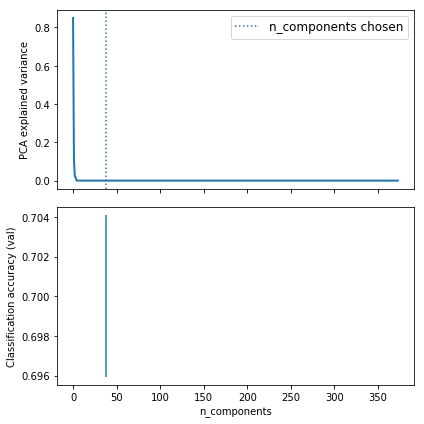

CPU times: user 2min 5s, sys: 4.24 s, total: 2min 9s
Wall time: 1min 28s


In [26]:
%%time



transformer = FunctionTransformer(np.log, validate=True)

scl = StandardScaler()

logistic = SGDClassifier(loss='modified_huber', max_iter=10000, tol=np.exp(-5), random_state=0)

pca = PCA()
pipe = Pipeline(steps=[('standardize', scl), # ('logarithm', transformer), 
                       ('pca', pca), ('logistic', logistic)])

# After having run a larger search: 
'''Best Parameter (CV score=0.765):
{'logistic__alpha': 0.15848931924611143, 'logistic__loss': 'modified_huber', 'logistic__penalty': 'l2', 'pca__n_components': 218}
CPU times: user 44min 51s, sys: 1min 46s, total: 46min 37s
Wall time: 23min 30s

'''
best = {'logistic__alpha': 0.15848931924611143, 'logistic__loss': 'log', 'logistic__penalty': 'l2',
       'pca__n_components': 38}
# param_grid = {
#     'pca__n_components': np.arange(b,NCm, a**b),
#     'logistic__alpha': np.logspace(-b**b, b**b, a),
#     'logistic__loss': ['modified_huber', 'log'], 
#     'logistic__penalty': ['l2', 'l1']
#}
param_grid = {
    'pca__n_components': [best['pca__n_components']],
    'logistic__alpha': [best['logistic__alpha']],
    'logistic__loss': [best['logistic__loss']],
    'logistic__penalty':[best['logistic__penalty']]
}

search = GridSearchCV(pipe, param_grid, iid=False, cv=5, scoring='recall_micro', return_train_score=False)
#search = GridSearchCV(pipe, param_grid, cv=5, scoring='recall')
search.fit(X, y)

print('Best Parameter (CV score=%0.5f):' % search.best_score_)
#print(search.best_params_)

#Plot the PCA spectrum
pca.fit(X)

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(pca.explained_variance_ratio_, linewidth=2)
ax0.set_ylabel('PCA explained variance')

print(pca.explained_variance_ratio_)


ax0.axvline(search.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
ax0.legend(prop=dict(size=12))

# For each number of components, find the best classifier results
results = pd.DataFrame(search.cv_results_)
components_col = 'param_pca__n_components'
best_clfs = results.groupby(components_col).apply(
    lambda g: g.nlargest(1, 'mean_test_score'))

best_clfs.plot(x=components_col, y='mean_test_score', yerr='std_test_score',
               legend=False, ax=ax1)
ax1.set_ylabel('Classification accuracy (val)')
ax1.set_xlabel('n_components')

plt.tight_layout()
plt.show()

In [27]:
pd.DataFrame(search.cv_results_).sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logistic__alpha,param_logistic__loss,param_logistic__penalty,param_pca__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,13.730938,0.194757,0.420945,0.020897,0.158489,log,l2,38,"{'logistic__alpha': 0.15848931924611143, 'logi...",0.69447,0.697753,0.699495,0.706734,0.701633,0.700017,0.004096,1


In [28]:
# pipe = Pipeline(steps=[('standardize', scl),
#                        ('pca', PCA(n_components=38)), 
#                        ('logistic', 
#     SGDClassifier(loss='log', max_iter=10000, tol=np.exp(-5), random_state=0, alpha = 0.15848931924611143,
#                   penalty='l2'))])

In [29]:
test_url = "unit-3/test_features.csv"
df = pd.read_csv(test_url, parse_dates=['date_recorded'],index_col='id' )
df['timestamp'] = df.date_recorded.apply(lambda d: d.timestamp()/ 10 ** 9)
dft = df.drop(['date_recorded', 'region_code', 'district_code', 'region'], inplace = False, axis=1)
dft['region_district'] = df.apply(lambda row: f'{row.region}_{row.district_code}' , axis=1)
# train_input_columns = list(dft.columns)
dft[dc] = ['fuctional'] * dft.shape[0]
dft.head()

,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,timestamp,region_district,status_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
50785,0.0,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,Internal,Magoma,Mbulu,Bashay,321,True,GeoData Consultants Ltd,Parastatal,NaN,True,2012,other,other,other,parastatal,parastatal,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other,1.359936,Manyara_3,fuctional
51630,0.0,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,Pangani,Kimnyak,Arusha Rural,Kimnyaki,300,True,GeoData Consultants Ltd,VWC,TPRI pipe line,True,2000,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,1.359936,Arusha_2,fuctional
17168,0.0,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,Internal,Msatu,Singida Rural,Puma,500,True,GeoData Consultants Ltd,VWC,P,NaN,2010,other,other,other,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other,1.359677,Singida_2,fuctional
45559,0.0,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,Ruvuma / Southern Coast,Kipindimbi,Liwale,Mkutano,250,NaN,GeoData Consultants Ltd,VWC,NaN,True,1987,other,other,other,vwc,user-group,unknown,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other,1.358813,Lindi_43,fuctional
49871,500.0,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,Ruvuma / Southern Coast,Losonga,Mbinga,Mbinga Urban,60,NaN,GeoData Consultants Ltd,Water Board,BRUDER,True,2000,gravity,gravity,gravity,water board,user-group,pay monthly,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,1.364342,Ruvuma_3,fuctional


In [30]:
dft.shape

(14358, 38)

In [31]:
# pd.set_option('display.max_columns', None)
# #train__ = copy.deepcopy(train_input_columns)
# test_input_columns = df_.columns
# test__ = list(df_.columns)
# for c in train_input_columns:
#     if c not in test_input_columns:
#         print(f'{c} not in test')
#     else:
#         test__.remove(c)
# print(test__)
        
    

In [32]:
# test_encoders = Pipeline([
#                 ('binary', BinaryEncoder(cols=binary)),
#                 ('onehot', ce.OneHotEncoder(use_cat_names=True,cols=hot))
#             ])
# test_df = test_encoders.fit_transform(df_)
#print(list(test_df.columns), train_columns)

In [33]:
# de_test = test_df.describe()
# ex_oc_test = test_df.columns
# drop_test = []
# for o in ex_oc:
#     if o in de.columns:
#         if de[o]['mean'] == 0:
#             drop_test.append(o)
#         # print(de[o].mean)
# dfd_test = test_df.drop(drop_test, axis=1)
# print(drop_test)

In [34]:
# #train__ = copy.deepcopy(train_columns)
# test_columns = dfd_test.columns
# test__ = list(dfd_test.columns)
# for c in train_columns:
#     if c not in test_columns:
#         print(f'{c} not in test')
#     else:
#         test__.remove(c)
# print(test__)

In [35]:
# del test_columns
# del test__
# del dfd_test
# del de_test
# del ex_oc_test
# del drop_test
# del test_encoders
# del test_df
# del test_input_columns
# del test__

In [36]:
dfd_ = encoders.transform(dft)
dfdf_ = dfd_.drop(drop, axis=1)

In [37]:
# dfdf_[dc] = ['functional'] * dfdf_.shape[0]
dfdf_.head()

,basin_Lake Nyasa,basin_Lake Victoria,basin_Pangani,basin_Ruvuma / Southern Coast,basin_Internal,basin_Lake Tanganyika,basin_Wami / Ruvu,basin_Rufiji,basin_Lake Rukwa,lga_Ludewa,lga_Serengeti,lga_Simanjiro,lga_Nanyumbu,lga_Karagwe,lga_Mkinga,lga_Shinyanga Rural,lga_Kahama,lga_Tabora Urban,lga_Mkuranga,lga_Namtumbo,lga_Maswa,lga_Siha,lga_Meatu,lga_Sumbawanga Rural,lga_Njombe,lga_Ukerewe,lga_Bariadi,lga_Same,lga_Kigoma Rural,lga_Moshi Rural,lga_Lindi Rural,lga_Rombo,lga_Chamwino,lga_Bagamoyo,lga_Mafia,lga_Arusha Rural,lga_Kyela,lga_Kondoa,lga_Kilolo,lga_Kibondo,lga_Makete,lga_Singida Rural,lga_Masasi,lga_Rungwe,lga_Moshi Urban,lga_Geita,lga_Mbulu,lga_Bukoba Rural,lga_Muheza,lga_Lushoto,lga_Meru,lga_Iramba,lga_Kilombero,lga_Mbarali,lga_Kasulu,lga_Bukoba Urban,lga_Korogwe,lga_Bukombe,lga_Morogoro Rural,lga_Kishapu,lga_Musoma Rural,lga_Sengerema,lga_Iringa Rural,lga_Muleba,lga_Dodoma Urban,lga_Ruangwa,lga_Hanang,lga_Misenyi,lga_Missungwi,lga_Songea Rural,lga_Tanga,lga_Tunduru,lga_Hai,lga_Mwanga,lga_Chato,lga_Biharamulo,lga_Ileje,lga_Mpwapwa,lga_Mvomero,lga_Bunda,lga_Kiteto,lga_Longido,lga_Urambo,lga_Mbozi,lga_Sikonge,lga_Ilala,lga_Tarime,lga_Temeke,lga_Mbeya Rural,lga_Magu,lga_Manyoni,lga_Igunga,lga_Kilosa,lga_Babati,lga_Chunya,lga_Mufindi,lga_Mtwara Rural,lga_Ngara,lga_Karatu,lga_Mpanda,lga_Kibaha,lga_Singida Urban,lga_Newala,lga_Nzega,lga_Nkasi,lga_Bahi,lga_Mbinga,lga_Ulanga,lga_Sumbawanga Urban,lga_Morogoro Urban,lga_Tandahimba,lga_Kisarawe,lga_Mtwara Urban,lga_Kilwa,lga_Liwale,lga_Kongwa,lga_Uyui,lga_Rufiji,lga_Kwimba,lga_Monduli,lga_Shinyanga Urban,lga_Ngorongoro,lga_Handeni,lga_Rorya,lga_Pangani,lga_Lindi Urban,lga_Nachingwea,lga_Kinondoni,lga_Kigoma Urban,lga_Ilemela,lga_Kilindi,lga_Arusha Urban,lga_Songea Urban,lga_Nyamagana,public_meeting_True,public_meeting_nan,public_meeting_False,recorded_by_GeoData Consultants Ltd,scheme_management_VWC,scheme_management_Other,scheme_management_nan,scheme_management_Private operator,scheme_management_WUG,scheme_management_Water Board,scheme_management_WUA,scheme_management_Water authority,scheme_management_Company,scheme_management_Parastatal,scheme_management_Trust,scheme_management_SWC,scheme_management_None,permit_False,permit_True,permit_nan,extraction_type_gravity,extraction_type_submersible,extraction_type_swn 80,extraction_type_nira/tanira,extraction_type_india mark ii,extraction_type_other,extraction_type_ksb,extraction_type_mono,extraction_type_windmill,extraction_type_afridev,extraction_type_other - rope pump,extraction_type_india mark iii,extraction_type_other - swn 81,extraction_type_other - play pump,extraction_type_cemo,extraction_type_climax,extraction_type_walimi,extraction_type_other - mkulima/shinyanga,extraction_type_group_gravity,extraction_type_group_submersible,extraction_type_group_swn 80,extraction_type_group_nira/tanira,extraction_type_group_india mark ii,extraction_type_group_other,extraction_type_group_mono,extraction_type_group_wind-powered,extraction_type_group_afridev,extraction_type_group_rope pump,extraction_type_group_india mark iii,extraction_type_group_other handpump,extraction_type_group_other motorpump,extraction_type_class_gravity,extraction_type_class_submersible,extraction_type_class_handpump,extraction_type_class_other,extraction_type_class_motorpump,extraction_type_class_wind-powered,extraction_type_class_rope pump,management_vwc,management_wug,management_other,management_private operator,management_water board,management_wua,management_company,management_water authority,management_parastatal,management_unknown,management_other - school,management_trust,management_group_user-group,management_group_other,management_group_commercial,management_group_parastatal,management_group_unknown,payment_pay annually,payment_never pay,payment_pay per bucket,payment_unknown,payment_pay when scheme fails,payment_other,payment_pay monthly,payment_type_annually,payment_type_never pay,payment_type_per bucket,payment_type_unknown,payment_type_on failure,payment_typ

In [38]:
dfdf_.shape

(14358, 375)

In [39]:
dfp = dfdf_.drop(dc, axis=1)

In [40]:
dfp.select_dtypes(include=['object']).columns

Index([], dtype='object')

In [41]:
dfy = search.best_estimator_.predict(dfp)

In [42]:
dfy.shape

(14358,)

In [43]:
with open('test.csv', 'w') as f:
    f.write('id,status_group\n')
    for fu,i in zip(dfy, dfp.index):
        f.write(f"{i},{fu}")
        f.write('\n')


In [166]:
# read in data

df_y = pd.DataFrame(y)
print(df_y[df_y.status_group == 'functional needs repair'].shape)
print(df_y[df_y.status_group == 'functional'].shape)
print(df_y[df_y.status_group == 'non functional'].shape)
y_true = [1 if s == 'functional needs repair' else (2 if s == 'functional' else 3) 
                              for s in df_y[dc].values]
# scle = scl.fit(X)
# Xs = scl.transform(X)
dtrain = xgb.DMatrix(X, label=y_true)
# specify parameters via map
# param = {'max_depth':2, 'eta':1, 'silent':1, 'objective':'reg:linear' }
param = {}
# use softmax multi-class classification
param['objective'] = 'multi:softmax'
# scale weight of positive examples
param['eta'] = 0.1
param['max_depth'] = 20
param['silent'] = 1
param['nthread'] = 4
param['num_class'] = 20
param['tree_method'] = 'gpu_exact'
num_round = 25
bst = xgb.train(param, dtrain, num_round)
# make prediction
# dfps = scl.transform(dfp)
test = xgb.DMatrix(dfp)

preds = bst.predict(test, predictor='gpu_predictor')


(4317, 1)
(32259, 1)
(22824, 1)


XGBoostError: b'[16:46:31] src/learner.cc:186: XGBoost version not compiled with GPU support.\n\nStack trace returned 10 entries:\n[bt] (0) /home/mark/anaconda3/lib/libxgboost.so(dmlc::StackTrace()+0x42) [0x7f0996019092]\n[bt] (1) /home/mark/anaconda3/lib/libxgboost.so(dmlc::LogMessageFatal::~LogMessageFatal()+0x18) [0x7f0996019698]\n[bt] (2) /home/mark/anaconda3/lib/libxgboost.so(xgboost::LearnerImpl::ConfigureUpdaters()+0x110) [0x7f0996025b60]\n[bt] (3) /home/mark/anaconda3/lib/libxgboost.so(xgboost::LearnerImpl::Configure(std::vector<std::pair<std::string, std::string>, std::allocator<std::pair<std::string, std::string> > > const&)+0x467) [0x7f09960285a7]\n[bt] (4) /home/mark/anaconda3/lib/libxgboost.so(XGBoosterUpdateOneIter+0x76) [0x7f099617aa16]\n[bt] (5) /home/mark/anaconda3/lib/python3.6/lib-dynload/../../libffi.so.6(ffi_call_unix64+0x4c) [0x7f09d0318ec0]\n[bt] (6) /home/mark/anaconda3/lib/python3.6/lib-dynload/../../libffi.so.6(ffi_call+0x22d) [0x7f09d031887d]\n[bt] (7) /home/mark/anaconda3/lib/python3.6/lib-dynload/_ctypes.cpython-36m-x86_64-linux-gnu.so(_ctypes_callproc+0x2ce) [0x7f09d052de2e]\n[bt] (8) /home/mark/anaconda3/lib/python3.6/lib-dynload/_ctypes.cpython-36m-x86_64-linux-gnu.so(+0x12865) [0x7f09d052e865]\n[bt] (9) /home/mark/anaconda3/bin/python(_PyObject_FastCallDict+0x8b) [0x556e4942fd7b]\n\n'

In [163]:
dfp.shape

(14358, 374)

In [164]:
vpreds = bst.predict(xgb.DMatrix(X))
print(r2_score(y_true, vpreds))
print(accuracy_score(y_true, vpreds))

0.808840803091
0.943434343434


In [165]:
with open('testxgb.csv', 'w') as f:
    f.write('id,status_group\n')
    for fu,i in zip(preds, dfp.index):
        index = round(fu)
        d = 'non functional' if index == 3 else ('functional' if index == 2 else 'functional needs repair')
        f.write(f"{i},{d}")
        f.write('\n')

In [129]:
dfum[dc].iloc[0:5][8776]

'functional'

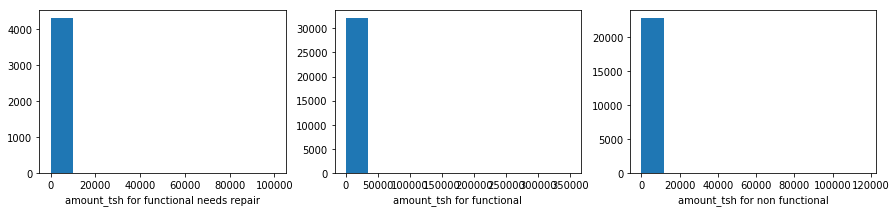

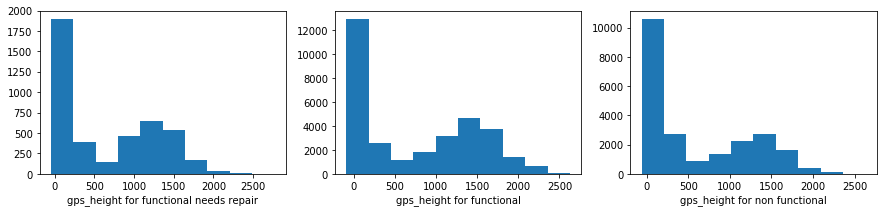

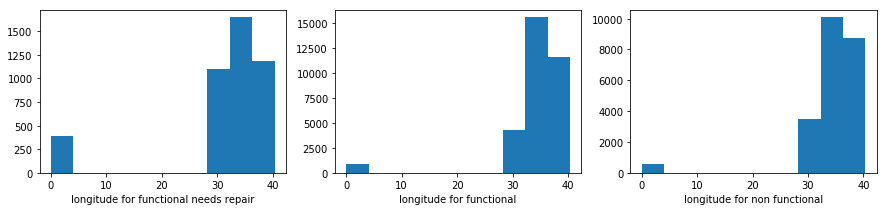

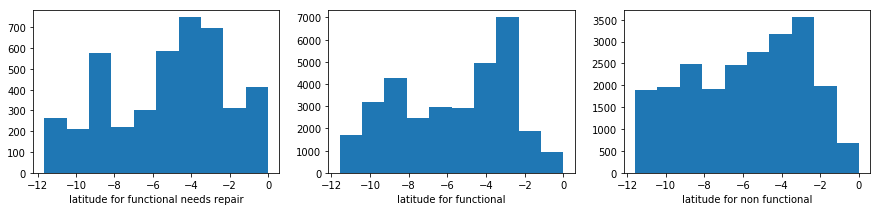

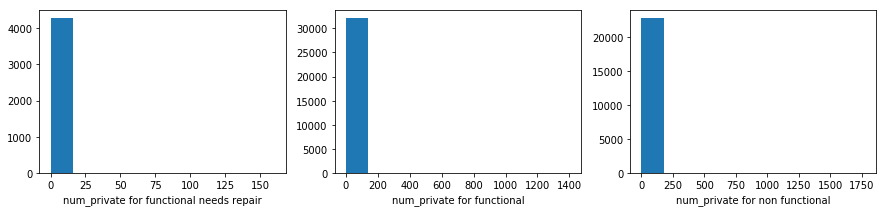

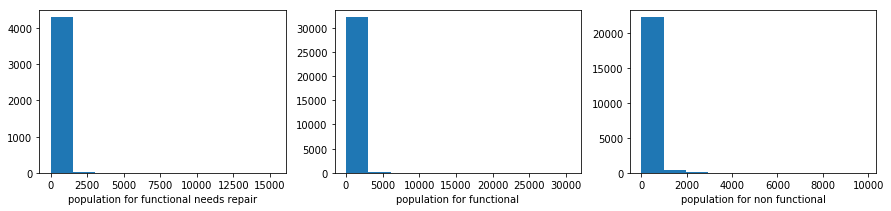

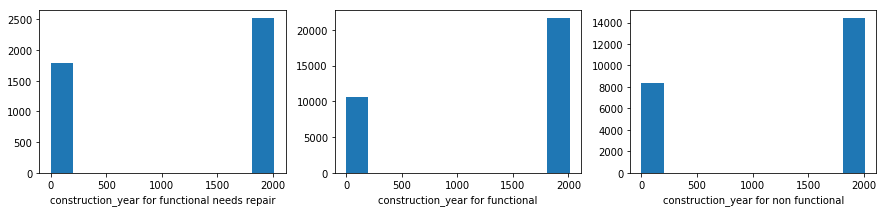

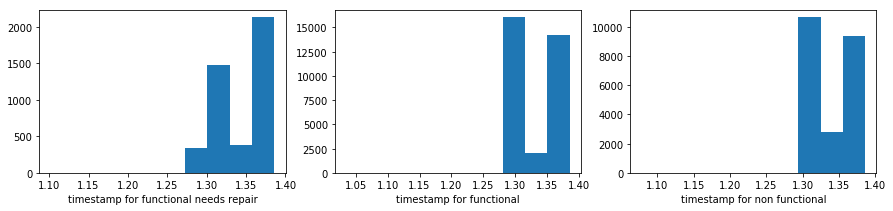

In [130]:
independant_columns  = dfum.select_dtypes(exclude=['object']).columns
one = 'functional needs repair'
two = 'functional'
three = 'non functional'
for c in independant_columns:
    fig, axs = plt.subplots(ncols=3)
    fig.set_size_inches(15, 3)
    axs[0].hist(dfum[dfum[dc] == one][c])
    axs[1].hist(dfum[dfum[dc] == two][c])
    axs[2].hist(dfum[dfum[dc] == three][c])
    axs[0].set_xlabel(f'{c} for functional needs repair')
    axs[1].set_xlabel(f"{c} for functional")
    axs[2].set_xlabel(f"{c} for non functional")
    plt.show()